# View on [nbviewer.jupyter.org](https://nbviewer.jupyter.org/github/icweaver/pyhat/blob/master/toymodel_gaussian.ipynb?flush_cache=true)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import utils

In [2]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# Standard example

## Sample data

This generates some random data sampled from a normal distribution.

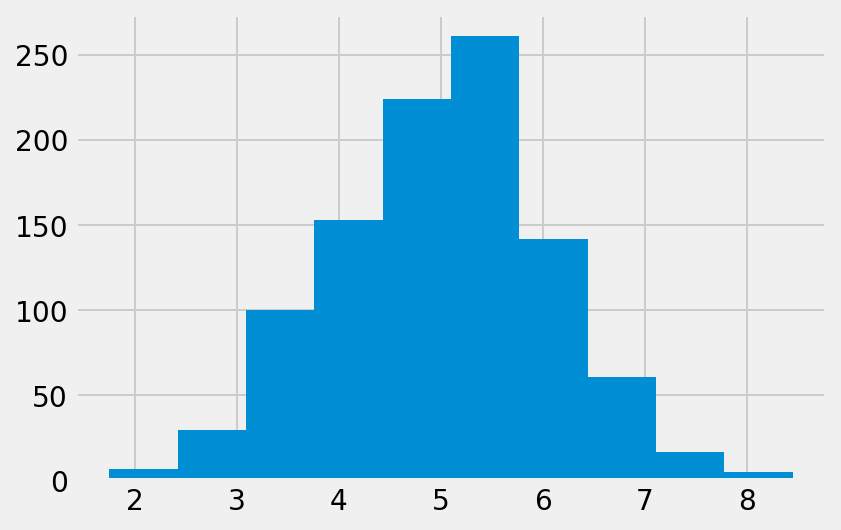

In [3]:
data = np.random.normal(loc=5.0, size=1_000)
plt.hist(data, bins=10)
plt.show()

## Fit with `pymc3`

For this toy model, let's fit a normal model with uniform priors to see if we get back what we expect:

In [4]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=0.0, upper=10.0)
    sigma = pm.Uniform("sigma", lower=0.0, upper=2.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=data)

with model:
    trace = pm.sample(1_000, chains=4, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3704.73draws/s]


The traces show that things seem ok.

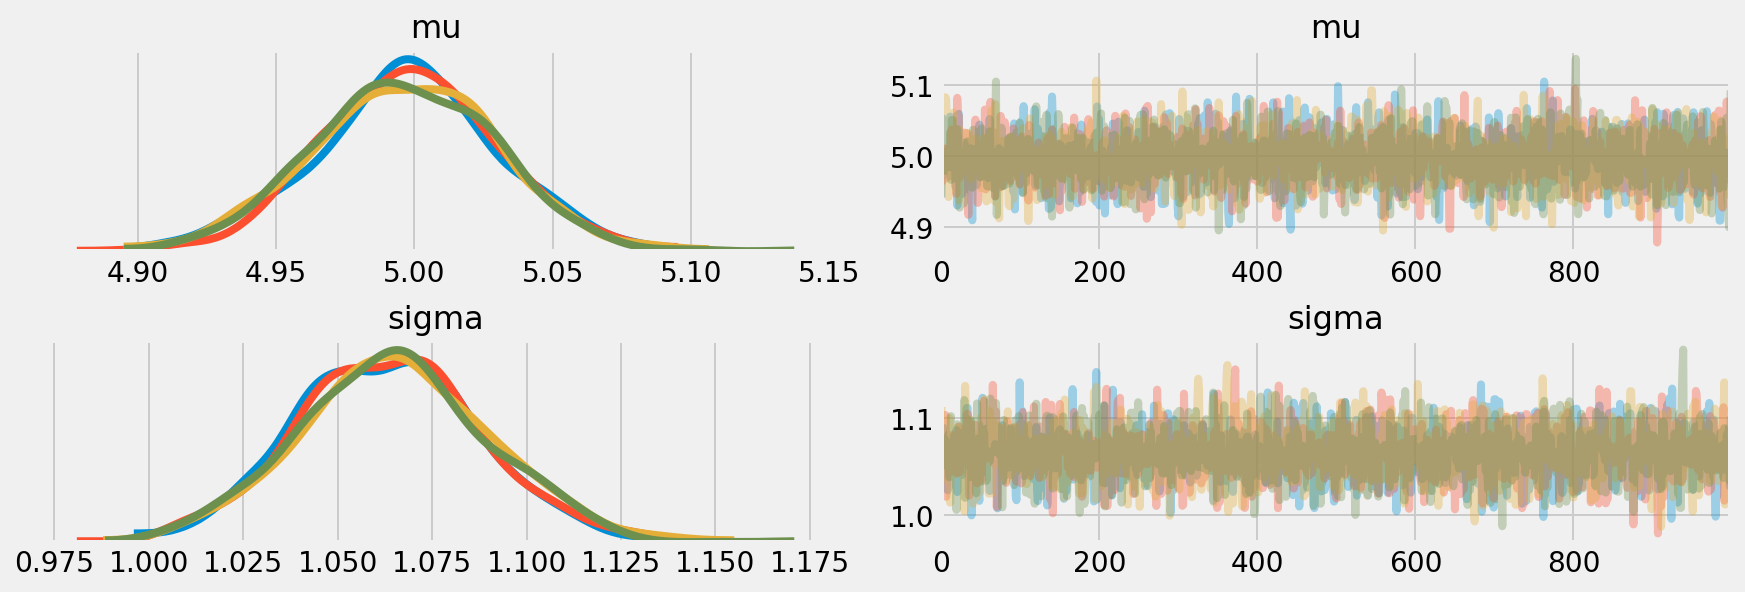

In [5]:
pm.traceplot(trace)
plt.show()

$\newcommand{\rhat}{\hat R}$
We can explore this in more detail by using the $\rhat$ diagnostic, defined as:

$$
\rhat = \sqrt{\frac{\widehat{\text{var}}^+(\theta|y)}{W}},\quad
\widehat{\text{var}}^+(\theta|y) = \frac{N - 1}{N}W + \frac{1}{N}B,\quad
$$

where $\widehat{\text{var}}^+(\theta|y)$ is the marginal posterior variance of the parameters $\theta$ given the data $y$, $N$ is the number of samples in our MCMC chain, and $B$ and $W$ are the standard between- and within-chain variances defined in Equations 1 and 2 of the paper, respectively. A similar, but more robust diagnostic metric, split-$\rhat$ is calculated in the same way, only the chains are split in half, doubling $M$ and halving $N$. This has the added benefit of being sensitive to non-stationary chains. 

Let's check if our implementation of the old version of $\rhat$ agree with the one baked into the popular python package, `pymc3`.

In [6]:
# compare to pymc3
params = ["mu", "sigma"]
for param in params:
    rhat_old = utils.rhat(trace, param, split=False)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(f"{param}: {np.isclose(rhat_old, rhat_pymc)}")

mu: True
sigma: True


It looks like `pymc3` is using the standard definition for $\rhat$, which has since been outdated by the split-$\rhat$ method. Let's check that next.

In [7]:
# compare to pymc3
params = ["mu", "sigma"]
for param in params:
    rhat_split = utils.rhat(trace, param, split=True)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(param) 
    print(f"rhat_split: {rhat_split}")
    print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_split: 0.9993854694491064
rhat_pymc:  0.9997389553038809

sigma
rhat_split: 1.0008428170277346
rhat_pymc:  1.0006603206876135



We can see here that the split-$\rhat$ method can actually differ from the standard definition, even for a basic case like this. Let's test its robustness next by testing what happens if one of our chains happens to start in a different place in the parameter space.

# Shifted example

Using the same chains from the previous example, let's simulate the first one starting in a different place by artificially shifting it by some value $c$.

In [8]:
c = 0.008
params = ["mu", "sigma"]
for param in params:
    trace_shifted_array = np.array(trace.get_values(param, combine=False)) 
    #trace_shifted_array[0, :] += c
    chain_1 = trace_shifted_array[0, :]
    #chain_1 -= 0.0000001*(chain_1 - np.mean(chain_1))
    chain_1 += c
    rhat_split = utils.rhat(trace_shifted_array, param, split=True)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(param) 
    print(f"rhat_split: {rhat_split}")
    print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_split: 1.0063426480255309
rhat_pymc:  0.9997389553038809

sigma
rhat_split: 1.0072714913000476
rhat_pymc:  1.0006603206876135



This slight shift caused a noticeable increase in split-$\rhat$, while the standard $\rhat$ would make us think that the chains have actually converged. This is especially dangerous if we look at the trace plot.

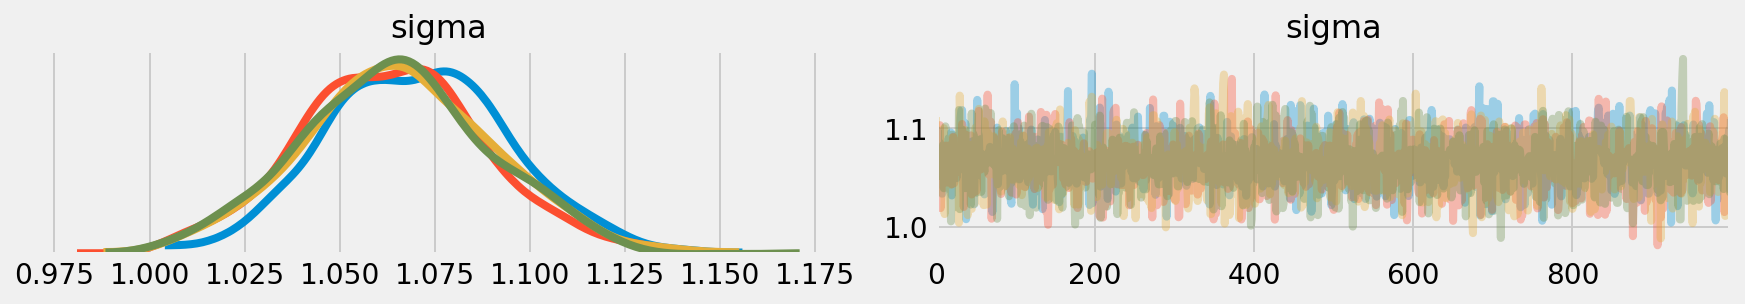

In [9]:
trace_shifted = {"sigma":trace_shifted_array}
pm.traceplot(trace_shifted)
plt.show()

By eye, the chains look well mixed and the shifted chain (blue) can look visually similar to the other chains. If we were just relying on this standard trace plot or $\rhat$ definition, we would come to the misleading conclusion that our simulation has converged for this basic toy model. The rule of thumb is that sampler results with $\rhat$ values greater than 1.01 should be treated with additional caution. 

Even though the current implementation of split-$\rhat$ does a little bit better in alerting us that the chains are not well mixed, it is still borderline. This next example will show a method to further improve the reliability of split-$\rhat$ explored in the paper.

# Rank normalized $\rhat$

This new method uses the same implementation of split-$\rhat$, but first transforms the chains before computing it. The transformation is given by Equation 6 in the text:

$$
z^{(nm)} = \Phi^{-1}\left[\frac{r^{(nm)} - 0.5}{S}\right] \quad,
$$

where $r^{(nm)}$ is the rank of $\theta^{(nm)}$, the $n$th parameter estimate of $N$ samples in the $m$th chain of $M$ total chains, and $S$ is the effective sample size estimate, and $\Phi^{-1}$ is the inverse normal transform.

In [11]:
param = "sigma"
theta = trace_shifted_array
theta = np.r_[tuple(np.hsplit(theta, 2))] # split and stack
ranks = np.argsort(theta)
S = utils.S_eff(theta, param)
arg = (ranks - 0.5) / S
z = sp.stats.invgauss.pdf(arg, mu=np.mean(arg))

rhat_rank = utils.rhat(z, param)
print(param) 
print(f"rhat_rank:  {rhat_rank}")

sigma
rhat_rank:  0.9992742394539
